In [1]:
# Normal Imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [121]:
metricsdf = pd.read_csv('merged_dataframe_updated.csv')

mat_df=metricsdf[['DNA_UNIQUE_ID','Variety Group (Tree)1',
                  'days_to_mat','source_country','rice_blast']]
print mat_df.shape
mat_df.head()

(2347, 5)


,DNA_UNIQUE_ID,Variety Group (Tree)1,days_to_mat,source_country,rice_blast
0,IRIS 313-9783,Japonica,110,AFGHANISTAN,NaN
1,IRIS 313-10509,Indica,164,AFRICA,Susceptible
2,IRIS 313-9778,Indica,119,ARGENTINA,NaN
3,IRIS 313-9980,Japonica,110,ARGENTINA,NaN
4,IRIS 313-9795,Indica,135,AUSTRALIA,Susceptible


count: 2344
min: 80
max: 214
mean: 131.939419795
std: 24.4010276948


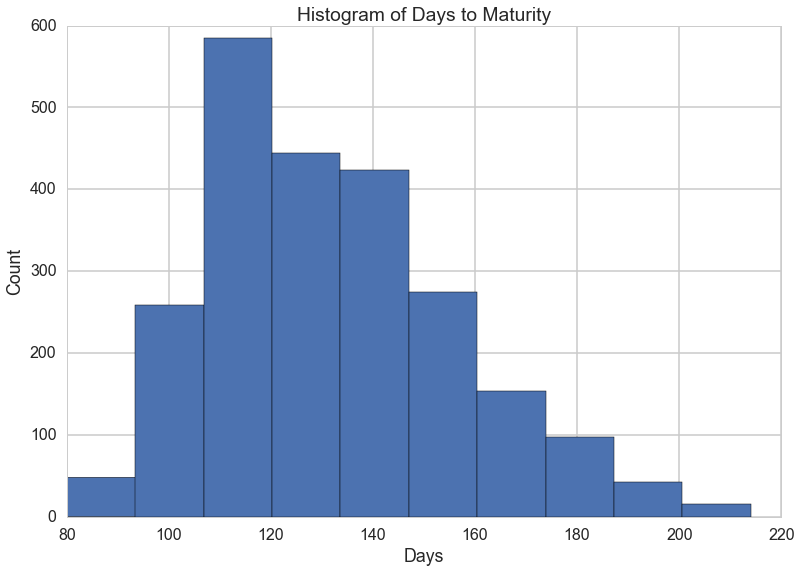

In [122]:
mat_df = mat_df[mat_df['days_to_mat'] != 0]

plt.hist(mat_df['days_to_mat'])
plt.title("Histogram of Days to Maturity")
plt.xlabel("Days")
plt.ylabel("Count")

days_list = np.array(mat_df['days_to_mat'])

print "count: " + str(len(days_list))
print "min: " + str(days_list.min())
print "max: " + str(days_list.max())
print "mean: " + str(days_list.mean())
print "std: " + str(days_list.std())

In [124]:
from sklearn.cross_validation import train_test_split

itrain, itest = train_test_split(xrange(mat_df.shape[0]), train_size=0.7)
mask=np.ones(mat_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask.shape, mask.sum()

((2344,), 1640)

In [145]:
from sklearn.preprocessing import StandardScaler

mat_df[['days_to_mat']] = mat_df[['days_to_mat']].astype(float)

std_scale = StandardScaler().fit(mat_df[mask]['days_to_mat'])
mat_df['stdardized_mat'] = std_scale.transform(mat_df['days_to_mat'])

days_list = np.array(mat_df[mask]['days_to_mat'])

mat_df['z_score'] = [(((mat_df['days_to_mat'])- days_list.mean())/days_list.std())][0]
fast_grow = [mat_df['days_to_mat'] < (days_list.mean() - days_list.std())]
mat_df['fast'] = fast_grow[0]

mat_df.head()

,DNA_UNIQUE_ID,Variety Group (Tree)1,days_to_mat,source_country,rice_blast,fast,stdardized_mat,z_score
0,IRIS 313-9783,Japonica,110,AFGHANISTAN,NaN,False,-0.910445,-0.910445
1,IRIS 313-10509,Indica,164,AFRICA,Susceptible,False,1.329374,1.329374
2,IRIS 313-9778,Indica,119,ARGENTINA,NaN,False,-0.537142,-0.537142
3,IRIS 313-9980,Japonica,110,ARGENTINA,NaN,False,-0.910445,-0.910445
4,IRIS 313-9795,Indica,135,AUSTRALIA,Susceptible,False,0.126508,0.126508


In [194]:
print "% fast: " + str(sum(mat_df[mask]['fast'])/float(len((mat_df[mask]['fast']))) * 100)
print "% slow: " + str((1. -sum(mat_df[mask]['fast'])/float(len((mat_df[mask]['fast'])))) * 100)

% fast: 15.1829268293
% slow: 84.8170731707


BASE LINE THEN PREDICTS THAT EVERYTHING IS SLOW IS 85% ACCURATE

In [142]:
mat_df.to_csv('mat_df.csv')

In [163]:
variety_days = {}

for idx, row in enumerate(mat_df[mask].index):
    variety = mat_df[mask].iloc[idx]['Variety Group (Tree)1']
    days = mat_df[mask].iloc[idx]['days_to_mat']
    if variety not in variety_days.keys():
        variety_days.update({variety:[days]})
    else:
        variety_days.get(variety).append(days)
for key in variety_days.keys():
    days = np.mean(variety_days.get(key))
    variety_days.update({key:days})
    
variety_days

{'Aus/boro': 112.86206896551724,
 'Basmati/sadri': 129.97435897435898,
 'Indica': 139.51117886178861,
 'Intermediate type': 127.40000000000001,
 'Japonica': 127.92207792207792,
 'Temperate japonica': 110.52884615384616,
 'Tropical japonica': 124.29237288135593}

In [191]:
from sklearn.metrics import confusion_matrix

a = []
for row in enumerate(mat_df[~mask].index):
    variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
    pred = (0.5*days_list.mean() + 0.5*variety_days.get(variety))
    if pred < (days_list.mean() - days_list.std()):
        a.append(True)
    else:
        a.append(False)
        
conf = confusion_matrix(mat_df[~mask]['fast'], a)
        
print conf
print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"

[[599   0]
 [105   0]]
Accuracy: 85.0852272727%


In [207]:
source_days = {}

for idx, row in enumerate(mat_df[mask].index):
    source = mat_df[mask].iloc[idx]['source_country']
    days = mat_df[mask].iloc[idx]['days_to_mat']
    if source not in source_days.keys():
        source_days.update({source:[days]})
    else:
        source_days.get(source).append(days)
for key in source_days.keys():
    days = np.mean(source_days.get(key))
    num = len(source_days.get(key))
    source_days.update({key:(days,num)})
    
source_days.keys()[0],source_days.get(source_days.keys()[0])

('LIBERIA', (124.25, 16))

In [309]:
a = []
print (days_list.mean() - days_list.std())
for row in enumerate(mat_df[~mask].index):
    variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
    source = mat_df[~mask].iloc[row[0]]['source_country']
    if source in source_days.keys():
        pred = (days_list.mean()+variety_days.get(variety)+500*source_days.get(source)[0])/502
    else:
        pred = (days_list.mean()+variety_days.get(variety))/2
        
    if pred < (days_list.mean() - days_list.std()):
        a.append(True)
    else:
        a.append(False)
    b.append(pred)
conf = confusion_matrix(mat_df[~mask]['fast'], a)
    
print np.min(b)
print conf
print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"

107.840899654
-0.620473705895
[[593   6]
 [ 92  13]]
Accuracy: 86.0795454545%


In [288]:
train_df = mat_df[mask]

train_var_days = []
train_source_days = []
for row,_ in enumerate(train_df.index):
    var = train_df.iloc[row]['Variety Group (Tree)1']
    source = train_df.iloc[row]['source_country']
    if source in source_days.keys():
        train_source_days.append((source_days.get(source)[0]))
    else:
        train_source_days.append(days_list.mean())
    train_var_days.append((variety_days.get(var)))
    
train_df.loc[:,'source_val'] = pd.Series(train_source_days)
train_df.loc[:,'var_val'] = pd.Series(train_var_days)
train_df.loc[:,'mean'] = days_list.mean()

train_df.head()

,DNA_UNIQUE_ID,Variety Group (Tree)1,days_to_mat,source_country,rice_blast,fast,stdardized_mat,z_score,source_val,var_val,mean
0,IRIS 313-9783,Japonica,110,AFGHANISTAN,NaN,False,-0.910445,-0.910445,110.000,127.922078,131.95
2,IRIS 313-9778,Indica,119,ARGENTINA,NaN,False,-0.537142,-0.537142,114.500,127.922078,131.95
3,IRIS 313-9980,Japonica,110,ARGENTINA,NaN,False,-0.910445,-0.910445,135.000,139.511179,131.95
4,IRIS 313-9795,Indica,135,AUSTRALIA,Susceptible,False,0.126508,0.126508,119.000,124.292373,131.95
5,IRIS 313-9771,Tropical japonica,119,AUSTRIA,NaN,False,-0.537142,-0.537142,127.384,112.862069,131.95


In [276]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

ols_model = ols('days_to_mat ~ source_val + var_val + mean', train_df).fit()
ols_model.params

Intercept     0.003576
source_val    0.293890
var_val       0.229555
mean          0.471799
dtype: float64

In [278]:
a = []
mean = days_list.mean()

for row in enumerate(mat_df[~mask].index):
    variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
    source = mat_df[~mask].iloc[row[0]]['source_country']
    
    if source in source_days.keys():
        pred = (ols_model.params.Intercept + ols_model.params.source_val*source_days.get(source)[0]
        + ols_model.params.var_val*variety_days.get(variety) + ols_model.params['mean']*mean)
   
    else:
        pred = (ols_model.params.Intercept + ols_model.params.source_val*mean
        + ols_model.params.var_val*variety_days.get(variety) + ols_model.params['mean']*mean)

    if pred < (days_list.mean() - days_list.std()):
        a.append(True)
    else:
        a.append(False)
    b.append(pred)
conf = confusion_matrix(mat_df[~mask]['fast'], a)
    
print np.min(b)
print conf
print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"

0.00357559125767
[[599   0]
 [105   0]]
Accuracy: 85.0852272727%


In [295]:
stddays_list = [item for item in mat_df[mask]['stdardized_mat']]
stdmean = np.mean(stddays_list)
print stdmean

stdvariety_days = {}

for idx, row in enumerate(mat_df[mask].index):
    variety = mat_df[mask].iloc[idx]['Variety Group (Tree)1']
    days = mat_df[mask].iloc[idx]['stdardized_mat']
    if variety not in stdvariety_days.keys():
        stdvariety_days.update({variety:[days]})
    else:
        stdvariety_days.get(variety).append(days)
for key in stdvariety_days.keys():
    days = np.mean(stdvariety_days.get(key))
    stdvariety_days.update({key:days})
    
stdsource_days = {}

for idx, row in enumerate(mat_df[mask].index):
    source = mat_df[mask].iloc[idx]['source_country']
    days = mat_df[mask].iloc[idx]['stdardized_mat']
    if source not in stdsource_days.keys():
        stdsource_days.update({source:[days]})
    else:
        stdsource_days.get(source).append(days)
for key in stdsource_days.keys():
    days = np.mean(stdsource_days.get(key))
    num = len(stdsource_days.get(key))
    stdsource_days.update({key:(days,num)})
    
stdtrain_var_days = []
stdtrain_source_days = []
for row,_ in enumerate(train_df.index):
    var = train_df.iloc[row]['Variety Group (Tree)1']
    source = train_df.iloc[row]['source_country']
    if source in stdsource_days.keys():
        stdtrain_source_days.append((stdsource_days.get(source)[0]))
    else:
        stdtrain_source_days.append(0)
    stdtrain_var_days.append((stdvariety_days.get(var)))
    
train_df.loc[:,'stdsource_val'] = pd.Series(stdtrain_source_days)
train_df.loc[:,'stdvar_val'] = pd.Series(stdtrain_var_days)
train_df.loc[:,'mean'] = days_list.mean()
train_df.loc[:,'std_mean'] = 0
tran_df.head()

4.76583542278e-16


,DNA_UNIQUE_ID,Variety Group (Tree)1,days_to_mat,source_country,rice_blast,fast,stdardized_mat,z_score,source_val,var_val,mean,stdsource_val,stdvar_val,std_mean
0,IRIS 313-9783,Japonica,110,AFGHANISTAN,NaN,False,-0.910445,-0.910445,110.000,127.922078,131.95,-0.910445,-0.167071,0
2,IRIS 313-9778,Indica,119,ARGENTINA,NaN,False,-0.537142,-0.537142,114.500,127.922078,131.95,-0.723793,-0.167071,0
3,IRIS 313-9980,Japonica,110,ARGENTINA,NaN,False,-0.910445,-0.910445,135.000,139.511179,131.95,0.126508,0.313623,0
4,IRIS 313-9795,Indica,135,AUSTRALIA,Susceptible,False,0.126508,0.126508,119.000,124.292373,131.95,-0.537142,-0.317624,0
5,IRIS 313-9771,Tropical japonica,119,AUSTRIA,NaN,False,-0.537142,-0.537142,127.384,112.862069,131.95,-0.189389,-0.791731,0


In [299]:
stdols_model = ols('stdardized_mat ~ stdsource_val + stdvar_val + std_mean', train_df).fit()
stdols_model.params

Intercept       -0.025880
stdsource_val    0.293890
stdvar_val       0.229555
std_mean         0.000000
dtype: float64

In [307]:
a = []

for row in enumerate(mat_df[~mask].index):
    variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
    source = mat_df[~mask].iloc[row[0]]['source_country']
    
    if source in stdsource_days.keys():
        pred = (stdols_model.params.Intercept + stdols_model.params.stdsource_val*stdsource_days.get(source)[0]
        + stdols_model.params.stdvar_val*stdvariety_days.get(variety))
   
    else:
        pred = (stdols_model.params.Intercept + stdols_model.params.stdvar_val*stdvariety_days.get(variety))

    if pred < (0 - np.std(stddays_list)):
        a.append(True)
    else:
        a.append(False)
    b.append(pred)
conf = confusion_matrix(mat_df[~mask]['fast'], a)
    
print np.min(b)
print conf
print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"

-0.620473705895
[[599   0]
 [105   0]]
Accuracy: 85.0852272727%


In [ ]:
# for row in enumerate(mat_df[~mask].index):
#     variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
#     source = mat_df[~mask].iloc[row[0]]['source_country']
    
#     if source in source_days.keys():
#         pred = (ols_model.params.Intercept + ols_model.params.source_val*source_days.get(source)[0]
#         + ols_model.params.var_val*variety_days.get(variety) + ols_model.params['mean']*mean)
   
#     else:
#         pred = (ols_model.params.Intercept + ols_model.params.source_val*mean
#         + ols_model.params.var_val*variety_days.get(variety) + ols_model.params['mean']*mean)

#     if pred < (days_list.mean() - days_list.std()):
#         a.append(True)
#     else:
#         a.append(False)
#     b.append(pred)
# conf = confusion_matrix(mat_df[~mask]['fast'], a)
    
# print np.min(b)
# print conf
# print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"